In [9]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')


In [10]:
def sharpenImage(image):
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)

def cropPart(img, x,y,w,h):
    y0 = y
    x0 = x
    y1 = (int)(y0+w)
    x1 = (int)(x0+h)
    return img[y0:y1, x0:x1]

def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

# Extract the percentage of white and of black
def getPercents(dom):
    th = 5
    white = 0
    others = 0
    for c in dom:
        blacking = []
        x = c["color"]
        if x[0] < th and x[1] < th and x[2] < th:
            others += c["color_percentage"]
        else:
            white += c["color_percentage"]
    return {"w":white, "b": others}

# Check if two areas are overlapping
def isOverlaping(a, b):
    if(((b[0] >= a[0] and b[0] <= a[2])and(b[2] >= a[0] and b[2] <= a[2]))
       and
       ((b[1] >= a[1] and b[1] <= a[3])and(b[3] >= a[1] and b[3] <= a[3]))):
        return True
    else:
        return False

# Get the dominance colors of image segment and 
# return the white/black ratio
# higher black of 65% or more indicate selected option
def getSelected(img):
    dominantColors = extractDominantColor(img)
    p = getPercents(dominantColors)
    return p
    
# 2nd Connect Component Analysis (CCA-2) of each area of interest
# this area of interest is each rectangular area with the answer options
def getSelectedOption(img):
    label_image = measure.label(img.copy(), background=1)
    register = []
    optionPicker = []
    multipleChoiceLetters = ["A","B","C","D","E"]
    trueOrFalse = [True, False]

    count = 0
    areaHeight = label_image.shape[0]
    for region in regionprops(label_image):
        # the bounding box coordinates
        minRow, minCol, maxRow, maxCol = region.bbox
        detector = (maxCol - minCol)/(maxRow - minRow)
        if(minCol > (areaHeight*(65/100)) and region.area > 50 and detector > 0.5 and detector < 1.5 and not checkOverlaps(register, (minRow, minCol, maxRow, maxCol))):
            register.append((minRow, minCol, maxRow, maxCol))
            box = cropPart(img.copy(), minCol, minRow, maxRow-minRow,  maxCol-minCol)
            data = getSelected(box)
            optionPicker.append({"shade": data["b"], "noshade": data["w"], "distance": minCol})
            count += 1    

    if(len(optionPicker) > 0):
        reOrdered = sorted(optionPicker, key=lambda k: k['distance']) 
        optionId = max(range(len(reOrdered)), key=lambda index: reOrdered[index]['shade'])
        selected = reOrdered[optionId]
        if(selected["shade"] > 0.5):
            if(len(optionPicker) == 4):
                return multipleChoiceLetters[optionId]
            elif(len(optionPicker) == 2):
                return trueOrFalse[optionId]
            else:
                return "Not Multiple Choice"
        else:
            return "No Selection"
    else:
        return "Not Multiple Choice"


In [11]:
# The original image is first converted to a binary image
# this is to make sure there are just two color component involved
# The first Connected Component Analysis (CCA-1) is performed to extract all
# areas of interests - each rectangular areas containing the answer options
def extractSelection(image):
    gray_image = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    sharpImg = sharpenImage(gray_image)
    thresh, bw_img = cv2.threshold(sharpImg, 128, 255, cv2.THRESH_BINARY)

    label_image = measure.label(bw_img.copy(), background=1)
    studentSelections = []
    # regionprops creates a list of properties of all the labelled regions
    questionNumber = 1
    for region in regionprops(label_image):
        if region.area < 400 or region.area > 1200:
            #if the region is so small then it's likely not a license plate
            continue
        # the bounding box coordinates
        minRow, minCol, maxRow, maxCol = region.bbox
        areaWidth = maxCol - minCol
        areaHeight = maxRow - minRow
        if(areaWidth/areaHeight > 3 and areaHeight/areaWidth > 0.1):
            answere_area = cropPart(bw_img.copy(), minCol, minRow, maxRow-minRow,  maxCol-minCol)
            studentSelection = getSelectedOption(answere_area)
            studentSelections.append({"number": questionNumber, "selection": studentSelection})
            questionNumber += 1
    return studentSelections

In [ ]:
# FIRST EXAMPLE

In [17]:
img = imutils.url_to_image("http://localhost/images/ppm/sheet4.png")

In [13]:
marked = extractSelection(img)

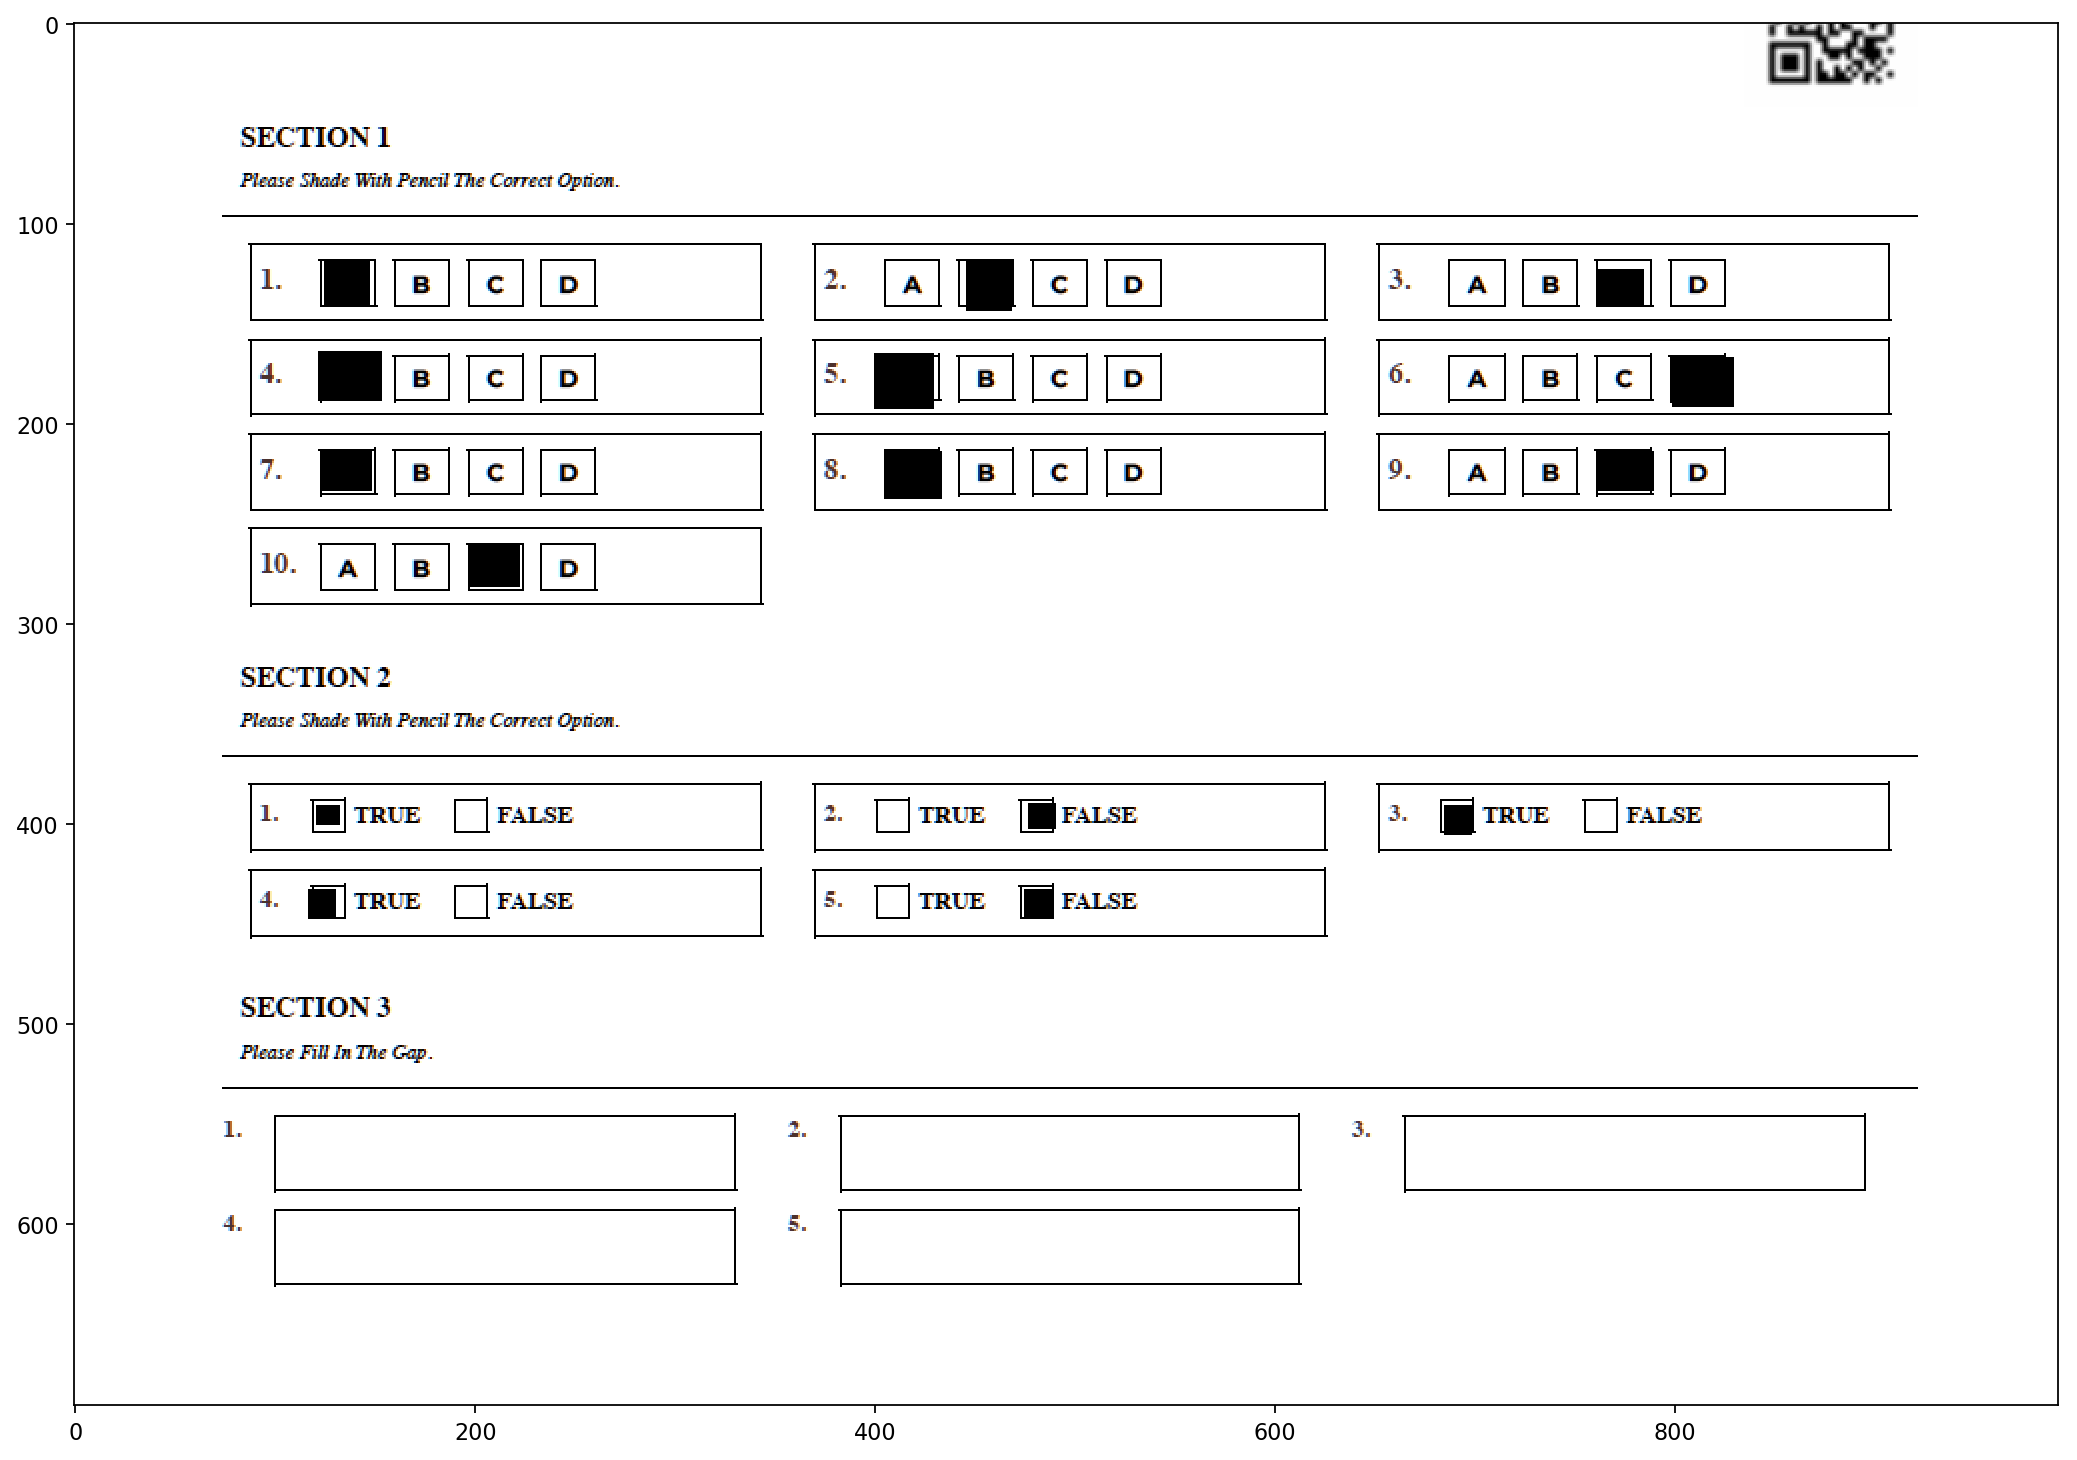

In [14]:
plt.subplots(1, figsize=(16, 12), dpi=160 )
plt.imshow(img)

In [15]:
for select in marked:
    print(select["number"]," - ", select["selection"])

1  -  A
2  -  B
3  -  C
4  -  A
5  -  A
6  -  D
7  -  A
8  -  A
9  -  C
10  -  C
11  -  True
12  -  False
13  -  True
14  -  True
15  -  False
16  -  Not Multiple Choice
17  -  Not Multiple Choice
18  -  Not Multiple Choice
19  -  Not Multiple Choice
20  -  Not Multiple Choice


In [ ]:
# SECOND EXAMPLE

In [20]:
img = imutils.url_to_image("http://localhost/images/ppm/sheet2.png")

In [21]:
marked = extractSelection(img)

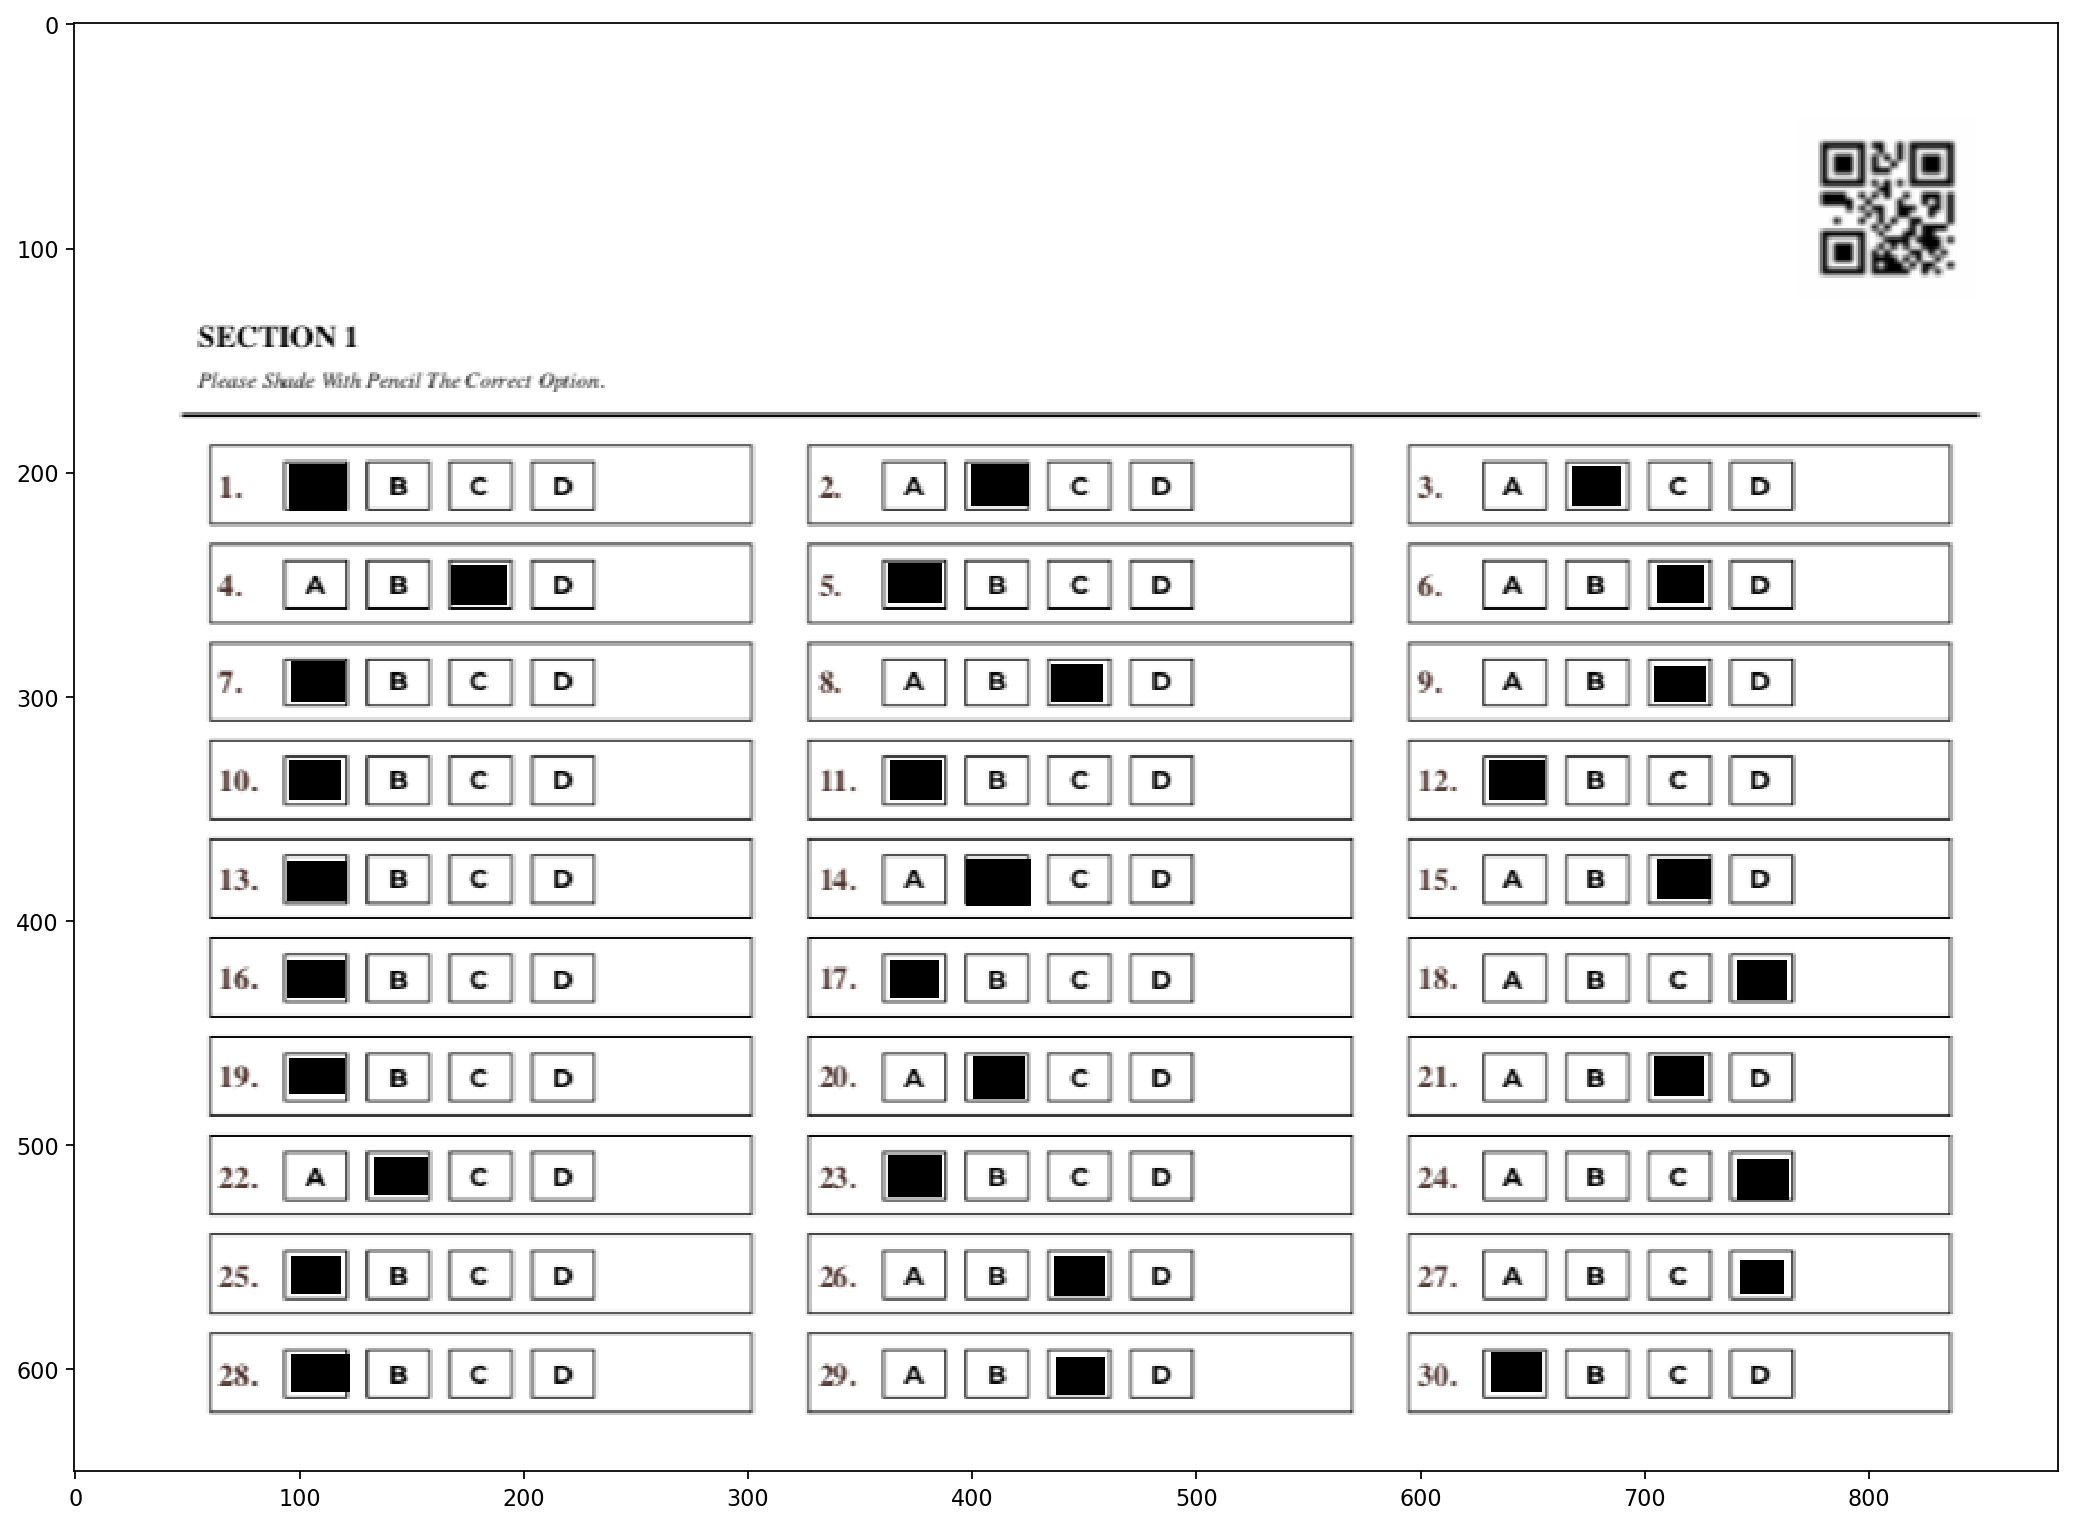

In [22]:
plt.subplots(1, figsize=(16, 12), dpi=160 )
plt.imshow(img)

In [23]:
for select in marked:
    print(select["number"]," - ", select["selection"])

1  -  A
2  -  B
3  -  B
4  -  C
5  -  A
6  -  C
7  -  A
8  -  C
9  -  C
10  -  A
11  -  A
12  -  A
13  -  A
14  -  B
15  -  C
16  -  A
17  -  A
18  -  D
19  -  A
20  -  B
21  -  C
22  -  B
23  -  A
24  -  D
25  -  A
26  -  C
27  -  D
28  -  A
29  -  C
30  -  A
